# Define Dependencies

In [1]:
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from tensorflow.keras.utils import to_categorical  # Use this instead of np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral
import matplotlib
%matplotlib inline


In [2]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])


# Define the neccesary functions for later use

In [3]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'Data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

def remap(labels):
    for i in range(145):
        for j in range(145):
            if labels[i, j] in [1, 2, 3]:
                labels[i, j] = 1
            elif labels[i, j] in [4, 5, 6]:
                labels[i, j] = 2
            elif labels[i, j] in [10, 11, 12]:
                labels[i, j] = 3
            else:
                labels[i, j] = 4
    return labels - 1

def reports (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Corn', 'Grass', 'Soyabean', 'Others']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy


def applyPCA(X, numPCAcomponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numPCAcomponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numPCAcomponents))
    return newX, pca

def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [4]:
X_test = np.load("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


y_test = np.load("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


In [5]:
from tensorflow.keras.utils import to_categorical  # Ensure this is imported at the top

# Reshape X_test as required
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))

# Convert y_test to one-hot encoding
num_classes = len(np.unique(y_test))  # Ensure you set the number of classes
y_test = to_categorical(y_test, num_classes=num_classes)


In [6]:
# load the model architecture and weights
model = load_model('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [7]:
# Using the pretrained model make predictions and print the results into a report
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9714 - loss: 0.1069  


# Build the Classification Maps

In [8]:
# load the original image
X, y = loadIndianPinesData()

In [9]:
print(X.shape)

(145, 145, 200)


In [10]:
print(y)
print(y.shape)

[[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(145, 145)


In [11]:
y = remap(y)

In [12]:
print(y)

[[0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


In [13]:
X,pca = applyPCA(X,numPCAcomponents)

In [14]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numPCAcomponents = numPCAcomponents

In [15]:
import numpy as np


outputs = np.zeros((height, width))
for i in range(height - PATCH_SIZE + 1):
    for j in range(width - PATCH_SIZE + 1):
        # Get the target value
        target = y[int(i + PATCH_SIZE / 2), int(j + PATCH_SIZE / 2)]
        
        # Skip processing if the target is 0
        if target == 0:
            continue
        
        # Extract the image patch
        image_patch = Patch(X, i, j)
        
        # Reshape the image patch for prediction
        X_test_image = image_patch.reshape(
            1, image_patch.shape[2], image_patch.shape[0], image_patch.shape[1]
        ).astype('float32')
        
        # Make a prediction using the model
        predictions = model.predict(X_test_image , verbose=0)
        
        # Get the predicted class
        prediction = np.argmax(predictions, axis=1)[0]  # Extract the scalar value
        
        # Update the output at the corresponding position
        outputs[int(i + PATCH_SIZE / 2)][int(j + PATCH_SIZE / 2)] = prediction

# Optional: Print the outputs or check values for debugging

In [16]:
np.unique(y)

array([0, 1, 2, 3], dtype=uint8)

In [17]:
import numpy as np
unique_classes = np.unique(y)
print(unique_classes)

[0 1 2 3]


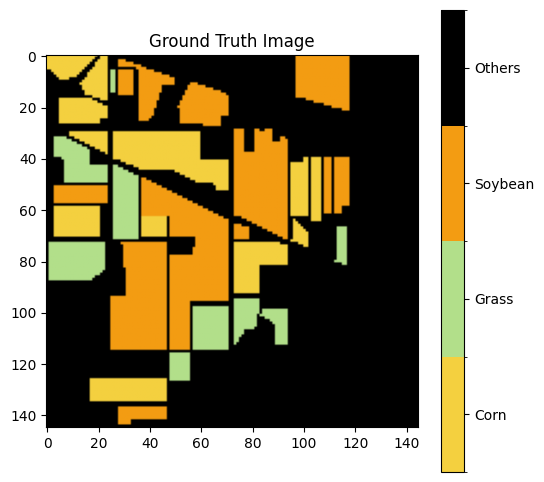

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Target class labels and number of classes
target_names = ['Corn', 'Grass', 'Soybean', 'Others']
num_classes = len(target_names)

# Define custom colors for each class
custom_colors = [
    '#f4d03f',   # Corn - golden yellow
    '#b2df8a',   # Grass - light yellow-green
    '#f39c12',   # Soybean - deep orange
    '#000000',   # Others - black
]

# Create a ListedColormap with your custom colors
custom_cmap = mcolors.ListedColormap(custom_colors)

# Create normalization to map class indices to colormap entries
bounds = np.arange(num_classes + 1) - 0.5  # [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)

# Show the image
plt.figure(figsize=(6, 6))
plt.imshow(y, cmap=custom_cmap, norm=norm)
plt.title('Ground Truth Image')

# Add colorbar with custom ticks and labels
cbar = plt.colorbar(ticks=np.arange(num_classes), boundaries=bounds)
cbar.ax.set_yticklabels(target_names)  # Set class names

plt.show()

In [19]:
np.unique(y), np.unique(outputs)

(array([0, 1, 2, 3], dtype=uint8), array([0., 1., 2., 3.]))

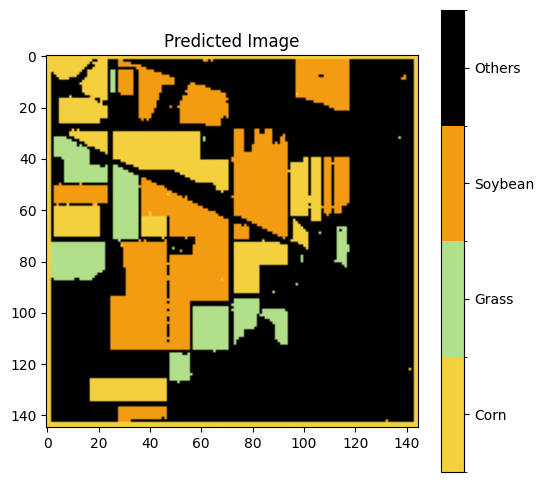

In [20]:
plt.figure(figsize=(6, 6))
plt.imshow(outputs.astype(int), cmap=custom_cmap, norm=norm)
plt.title('Predicted Image')

# Add colorbar with custom ticks and labels
cbar = plt.colorbar(ticks=np.arange(num_classes), boundaries=bounds)
cbar.ax.set_yticklabels(target_names)  # Set class names

plt.show()

In [21]:
#Compare ground truth and predicted image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Flatten the ground truth and predicted images
y_true = y.flatten()  # Ground truth labels
y_pred = outputs.flatten()  # Predicted labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

from sklearn.metrics import classification_report

# Generate classification report with zero_division set to 0
class_report = classification_report(y_true, y_pred, zero_division=0)
print("Classification Report:\n", class_report)

from sklearn.svm import SVC

# Initialize SVM with class_weight='balanced'
svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced')

Accuracy: 94.15%
Confusion Matrix:
 [[ 2304     0     0     0]
 [   15  1420     0    15]
 [   52     0  3946    22]
 [ 1051    21    54 12125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      2304
           1       0.99      0.98      0.98      1450
           2       0.99      0.98      0.98      4020
           3       1.00      0.92      0.95     13251

    accuracy                           0.94     21025
   macro avg       0.91      0.97      0.93     21025
weighted avg       0.96      0.94      0.95     21025



In [22]:
import numpy as np
unique_classes = np.unique(outputs)
print(unique_classes)


[0. 1. 2. 3.]
